In [4]:
import numpy as np
from hmmlearn import hmm
import warnings
from sklearn import neighbors, preprocessing
import pandas as pd
import seaborn as sns
from analytic import utility
from analytic import ta_indicators

from matplotlib import cm
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore", category=DeprecationWarning)

csv_files = ['SHA01']
sha_001_df = utility.get_cols_from_csv_names(csv_files, 
                                             interested_col=['Date', 'Close', 'Volume'], 
                                             join_spy=False,
                                             base_dir='/home/boweiliu/workrepo/udacity_p_f/src/rawdata')
# reverse
sha_001_df = sha_001_df.iloc[::-1].loc['2000-01-04':'2016-09-02']
close = sha_001_df['SHA01_CLOSE']
volume = sha_001_df['SHA01_VOLUME']
date_list = pd.to_datetime(close.index)

original_rtn = ta_indicators.get_daily_return(sha_001_df['SHA01_CLOSE'])
ln_rtn = ta_indicators.get_ln_return(close)
ln_rtn.iloc[0] = 0.0001
print('len(sha_001_df_drtn) : {}'.format(len(ln_rtn)))

sha_001_df_drtn_nparray = np.array(ln_rtn)
X = np.column_stack([sha_001_df_drtn_nparray])

trained_hmm = hmm.GaussianHMM(n_components=8, covariance_type='diag', n_iter=2000)
trained_hmm.fit(X)
# Predict the optimal sequence of internal hidden state
hidden_states_seq = trained_hmm.predict(X)
print("trained_hmm.transmat_:")
print(trained_hmm.transmat_)
print('len(hidden_states_seq) : {}'.format(len(hidden_states_seq)))

print("Means and vars of each hidden state")
for i in range(trained_hmm.n_components):
    print("{0}th hidden state".format(i))
    print("mean = ", trained_hmm.means_[i])
    print("var = ", np.diag(trained_hmm.covars_[i]))
    print()


len(sha_001_df_drtn) : 4037


trained_hmm.transmat_:
[[ 0.09401167  0.          0.          0.05567584  0.01085512  0.00405557
   0.00179816  0.83360364]
 [ 0.00364518  0.          0.          0.00093117  0.00000069  0.
   0.00000001  0.99542295]
 [ 0.08228595  0.          0.          0.05658615  0.          0.          0.
   0.86112791]
 [ 0.0958457   0.          0.          0.05657087  0.01975734  0.00547324
   0.0037858   0.81856706]
 [ 0.00542947  0.          0.          0.00667661  0.90431658  0.00000067
   0.08003152  0.00354515]
 [ 0.02230566  0.          0.          0.00619728  0.00010944  0.00000806
   0.00000085  0.97137871]
 [ 0.          0.          0.          0.          0.11149405  0.
   0.88850595  0.        ]
 [ 0.12757802  0.          0.          0.08050502  0.00006956  0.00019192
   0.00005365  0.79160183]]
len(hidden_states_seq) : 4037
Means and vars of each hidden state
0th hidden state
mean =  [-0.00042107]
var =  [ 0.00033618]

1th hidden state
mean =  [ 0.04454764]
var =  [1000.]

2th hidden

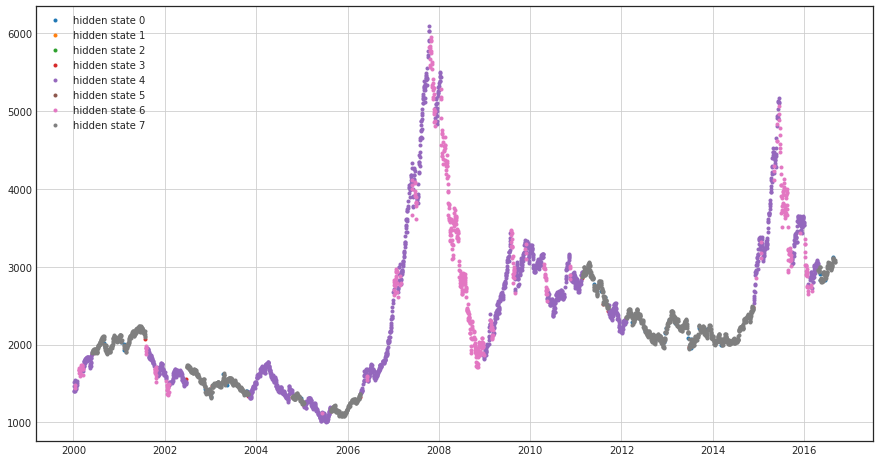

In [5]:
sns.set_style('white')
plt.figure(figsize=(15, 8))
for i in range(trained_hmm.n_components):
    state = (hidden_states_seq == i)
    plt.plot(date_list[state], close[state], '.', label='hidden state {}'.format(i),
             linewidth=1)
    plt.legend()
    plt.grid(1)
plt.show()

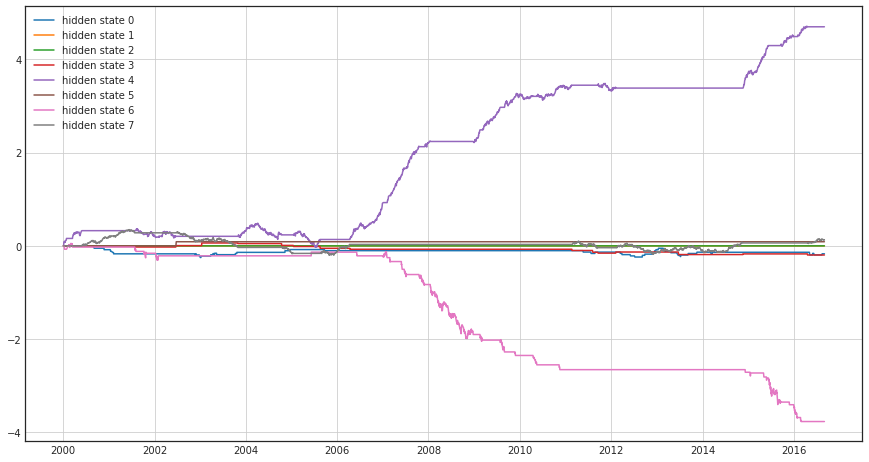

In [6]:
data = pd.DataFrame({
    'datelist': date_list,
    'ln_rtn': ln_rtn,
    'state': hidden_states_seq}).set_index('datelist')

plt.figure(figsize=(15, 8))
for i in range(trained_hmm.n_components):
    mask = [1 if state else 0 for state in (hidden_states_seq == i)]
    data['state %d_return' % i] = data.ln_rtn.multiply(mask, axis=0) 
    plt.plot(data['state %d_return' % i].cumsum(), label='hidden state {}'.format(i))
    plt.legend()
    plt.grid(1)
plt.show()